In [1]:
import matplotlib.pyplot as plt
from typing import Optional, List, Tuple, Dict
import pandas as pd
import os
import json
import numpy as np
from scipy import stats
from collections import defaultdict
import seaborn as sns

In [2]:
RESULTS_DIR_PATH = "/root/results"
KERNEL_PATCH_SUB_DIR="_kernel_patch"

def in_result_dir(result_dir_name):
    return os.path.join(RESULTS_DIR_PATH, result_dir_name)

def in_kernel_patch_dir(benchmark_dir_name) :
    return in_result_dir(os.path.join(KERNEL_PATCH_SUB_DIR, benchmark_dir_name))

In [3]:
def get_durations(filepath: str):
    with open(filepath, "r") as f:
        data = json.load(f)
    return data['results'][0]['times']

filename, file_extension = os.path.splitext('/path/to/somefile.ext')

[('no-nb', 10.305288739140002), ('nb-only', 10.051141685379996), ('nb-split', 9.208183601599998), ('nb-split-reapply-migrate', 9.096036477010001), ('nb-split-reapply', 9.084749115459998), ('nb-split-reapply-reset', 9.08037679194), ('nb-split-all', 9.071475657969996), ('no-nb-no-hp', 8.80022371404)]


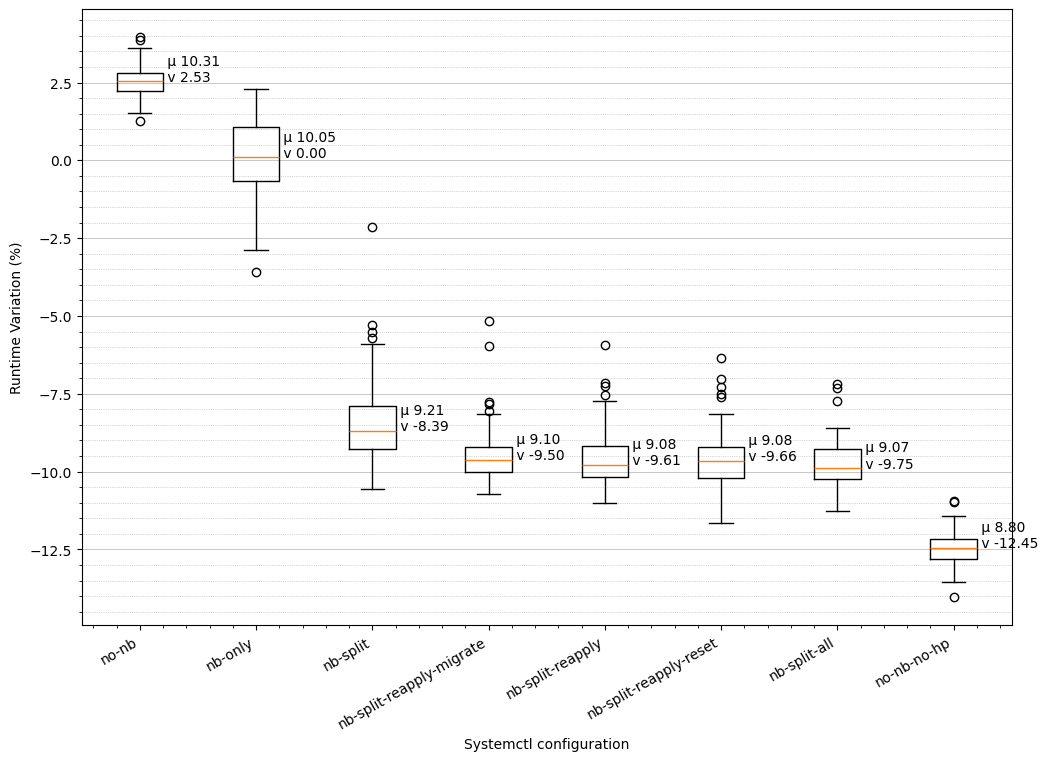

In [5]:
filepath = in_kernel_patch_dir("cg.C__dahu-29__split-aggressive/nb-only.json")
# get_durations(filepath)

def get_benchmark_durations_and_variations(benchmark_dir_path):
    duration_dict = {}
    variation_dict = {}
    averages = {}
    
    for filename in os.listdir(benchmark_dir_path):
        filepath = os.path.join(benchmark_dir_path, filename)
        if not os.path.isfile(filepath):
            continue
        basename, extension = os.path.splitext(filename)
        if extension != ".json":
            continue
        curr_durations = get_durations(filepath)
        duration_dict[basename] = curr_durations
        averages[basename] = (sum(curr_durations) / len(curr_durations))
    
    reference = averages["nb-only"]
    for config, durations in duration_dict.items():
        variations = [(d - reference) * 100 / reference for d in durations]
        variation_dict[config] = variations
    
    return duration_dict, variation_dict, sorted(averages.items(), key=lambda x: x[1], reverse=True)
        
durations, variations, averages = get_benchmark_durations_and_variations(in_kernel_patch_dir("cg.C__dahu-29__split-aggressive"))

print(averages)

# ordered_configs = [a[1] for a in averages]
# plt.boxplot(durations.values(), labels=durations.keys())
# plt.xticks(rotation=30, ha='right')
# plt.show()

# labels = [f"k\n{average : }"]

def average(l):
    return sum(l) / len(l)

labels = [a[0] for a in averages]
ordered_durations = [durations[l] for l in labels]
ordered_variations = [variations[l] for l in labels]
durations_np = np.array(ordered_durations)
avg = durations_np.mean(axis=1)
stddev = durations_np.std(axis=0)

bp = plt.boxplot(ordered_variations, labels=labels, widths=0.4)
ax = plt.gca()
# bp = ax.boxplot(data3, showmeans=True)

for i, line in enumerate(bp['medians']):
    x, y = line.get_xydata()[1]
    text = ' μ {:.2f}\n v {:.2f}'.format(avg[i], average(ordered_variations[i]))
    ax.annotate(text, xy=(x, y))

plt.minorticks_on()
plt.gcf().set_size_inches(12, 8)
plt.xticks(rotation=30, ha='right')
plt.grid(axis="y", which="major", linewidth=0.5)
plt.grid(axis="y", which="minor", linestyle=":", linewidth=0.5)
plt.ylabel("Runtime Variation (%)")
plt.xlabel("Systemctl configuration")
plt.show()

In [6]:
durations

{'nb-only': [9.90435431292,
  10.137819136920001,
  9.90303689792,
  10.00677567492,
  9.99792308292,
  9.797486345920001,
  10.001869113920002,
  10.24827234092,
  9.904738360920001,
  9.761781756920001,
  10.178330373920002,
  10.19887266992,
  10.177781751920001,
  10.01055294592,
  9.68928959992,
  9.807674224920001,
  10.10304122992,
  9.76124690792,
  10.17624223292,
  9.99832500592,
  10.04449778292,
  10.20519133492,
  10.21370982892,
  10.16590382492,
  10.03421079892,
  10.21908956292,
  10.10596410392,
  10.192265501920001,
  10.06406119592,
  9.868913672920002,
  10.104062287920001,
  9.96482625792,
  10.18031992092,
  9.979415382920001,
  9.81627549192,
  10.22964945392,
  10.15283909292,
  10.07286158392,
  9.86054143792,
  10.063989946920001,
  10.05396605492,
  10.19085603992,
  9.96625942492,
  9.94769988992,
  9.91290396492,
  10.16478732592,
  10.04925072892,
  9.845425310920001,
  10.057468680920001,
  9.990040371920001,
  10.035193489920001,
  10.10627852292,
  10.

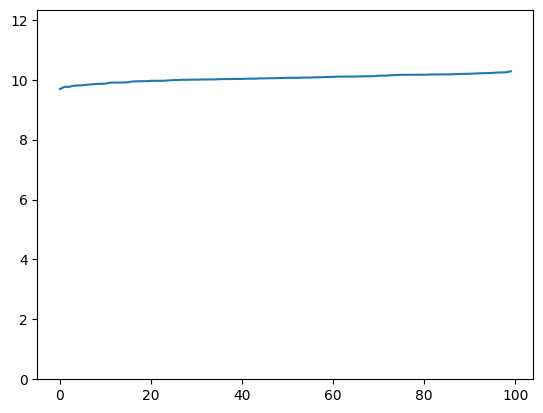

In [12]:

time_values = sorted(durations["nb-only"])
plt.plot(range(len(time_values)), time_values)
plt.ylim(0, time_values[-1] * 1.2)
plt.show()

